In [1]:
import deconV as dv
import scout

import glob, tqdm, time, os
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm
import scout

import plotly.express as px
import plotly.graph_objects as go

%load_ext autoreload
%autoreload 2

Global seed set to 0


In [2]:
params = {
    "cell_type_key": "cellType",
    "fig_fmt": "png",

    "selected_ct": ["alpha", "delta", "gamma", "beta"],
    "bulk_file": "../../data/xin/bulk.tsv",
    "ref_annot_file": "../../data/xin/pdata.tsv",
    "ref_file": "../../data/xin/sc.tsv",

    # "selected_ct": ["alpha", "delta", "gamma", "beta", "ductal", "acinar"],
    # "bulk_file": "../../data/pancreas/bulk.tsv",
    # "ref_annot_file": "../../data/pancreas/pdata.tsv",
    # "ref_file": "../../data/pancreas/sc.tsv",
    
    "outdir": "out",
    "figsize": (8,8),
    "dpi": 80,
}
true_df = pd.read_csv("../../data/xin/true.tsv", sep="\t", index_col=0)

sc.settings.set_figure_params(dpi=80, facecolor='white')
plt.rc("patch", edgecolor="black", facecolor="royalblue", linewidth=1.0)
plt.rc("axes", facecolor="white", edgecolor="black", linewidth=1.0)

sc.settings.verbosity = 0

In [3]:
true_df

,alpha,beta,delta,gamma
D6,0.603865,0.367150,0.024155,0.004831
D5,0.921212,0.066667,0.006061,0.006061
D4,0.492857,0.482143,0.017857,0.007143
D3,0.483333,0.433333,0.033333,0.050000
D2,0.602410,0.216867,0.060241,0.120482
D1,0.431818,0.136364,0.034091,0.397727
H12,0.626866,0.358209,0.014925,0.000000
H11,0.796610,0.169492,0.016949,0.016949
H10,0.418605,0.534884,0.046512,0.000000
H9,0.702703,0.189189,0.027027,0.081081


In [4]:
sadata = dv.tl.read_data(params["ref_file"])
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")

scRNA-seq data - cells: 1097, genes: 25453


In [5]:
print("Reading pheno data...")
pheno_df = pd.read_csv(params["ref_annot_file"], sep="\t", index_col=0)
pheno_df.index.name = None
common_cells = list(set(pheno_df.index.tolist()) & set(sadata.obs_names.tolist()))
len(common_cells)

Reading pheno data...


1097

In [6]:
sadata = sadata[common_cells, :].copy()
pheno_df = pheno_df.loc[common_cells, :].copy()
sadata.obs[params["cell_type_key"]] = pheno_df[params["cell_type_key"]].tolist()
sadata.obs.groupby(params["cell_type_key"]).size()

cellType
MHC class II                1
PSC                        23
acinar                    112
alpha                     443
beta                      171
co-expression              26
delta                      59
ductal                    135
endothelial                13
epsilon                     5
gamma                      75
mast                        4
unclassified                1
unclassified endocrine     29
dtype: int64

In [7]:
print("Reading bulk data...")
bulk_df = pd.read_csv(params["bulk_file"], sep="\t", index_col=None)
if bulk_df.iloc[:,0].dtype == "O":
    bulk_df.set_index(bulk_df.columns[0], inplace=True)
print(f"bulk RNA-seq data - samples: {bulk_df.shape[0]}, genes: {bulk_df.shape[1]}")

Reading bulk data...
bulk RNA-seq data - samples: 18, genes: 39849


In [8]:
if params["selected_ct"] is not None and len(params["selected_ct"]) > 0:
    sadata = sadata[sadata.obs[params["cell_type_key"]].astype("str").isin(params["selected_ct"]), :].copy()

sadata.obs[params["cell_type_key"]] = sadata.obs[params["cell_type_key"]].astype("category")
sadata.obs.groupby(params["cell_type_key"]).size()

cellType
alpha    443
beta     171
delta     59
gamma     75
dtype: int64

In [9]:
sc.pp.filter_cells(sadata, min_genes=200)
sc.pp.filter_genes(sadata, min_cells=3)
adata = dv.tl.combine(sadata, bulk_df)
scout.tl.scale_log_center(adata, target_sum=None, exclude_highly_expressed=True)

scRNA-seq data - cells: 748, genes: 17390
bulk RNA-seq data - samples: 18, genes: 17390


In [10]:
decon = dv.DeconV(adata, cell_type_key="cellType", sub_type_key=None, layer="counts")

In [11]:
# decon.filter_outliers(dropout_factor_quantile=0.9, pseudobulk_lims=(-10,10), aggregate="max")

In [12]:
decon.init_dataset(
    weight_type=None, weight_agg="max",
    inverse_weight=False, log_weight=False, quantiles=(0, 1) #0,1
)
# dv.pl.gene_weight_hist(
#     decon.adata.varm["gene_weights"],
#     f"Gene Weight (abs_score | min)",
#     logy=False,
# )

In [13]:
sc.tl.dendrogram(adata, "cellType")
import scipy.cluster.hierarchy as sch
root = sch.to_tree(adata.uns["dendrogram_cellType"]["linkage"])

def get_leaves(tree):
    if tree.is_leaf():
        return [tree.get_id()]
    else:
        return get_leaves(tree.get_left()) + get_leaves(tree.get_right())

def traverse(node):
    left = node.get_left()
    right = node.get_right()
    lefts = [left.get_id()] if left.is_leaf() else get_leaves(left)
    rights = [right.get_id()] if right.is_leaf() else get_leaves(right)

    adata.obs["super_type"] = adata.obs["cellType"].cat.codes.isin(lefts).astype("category")
    
    decon = dv.DeconV(adata, cell_type_key="super_type", sub_type_key=None, layer="counts")
    decon.filter_outliers(dropout_factor_quantile=0.9, pseudobulk_lims=(-10,10), aggregate="max")
    decon.init_dataset(
        weight_type=None, weight_agg="max",
        inverse_weight=False, log_weight=False, quantiles=(0, 1) #0,1
    )
    print(decon.deconvolute(progress_bar=False))
    print(lefts, " vs. ", rights)
    if not left.is_leaf(): traverse(left)
    if not right.is_leaf(): traverse(right)


traverse(root)

KeyError: 'dropout_weight_super_type'

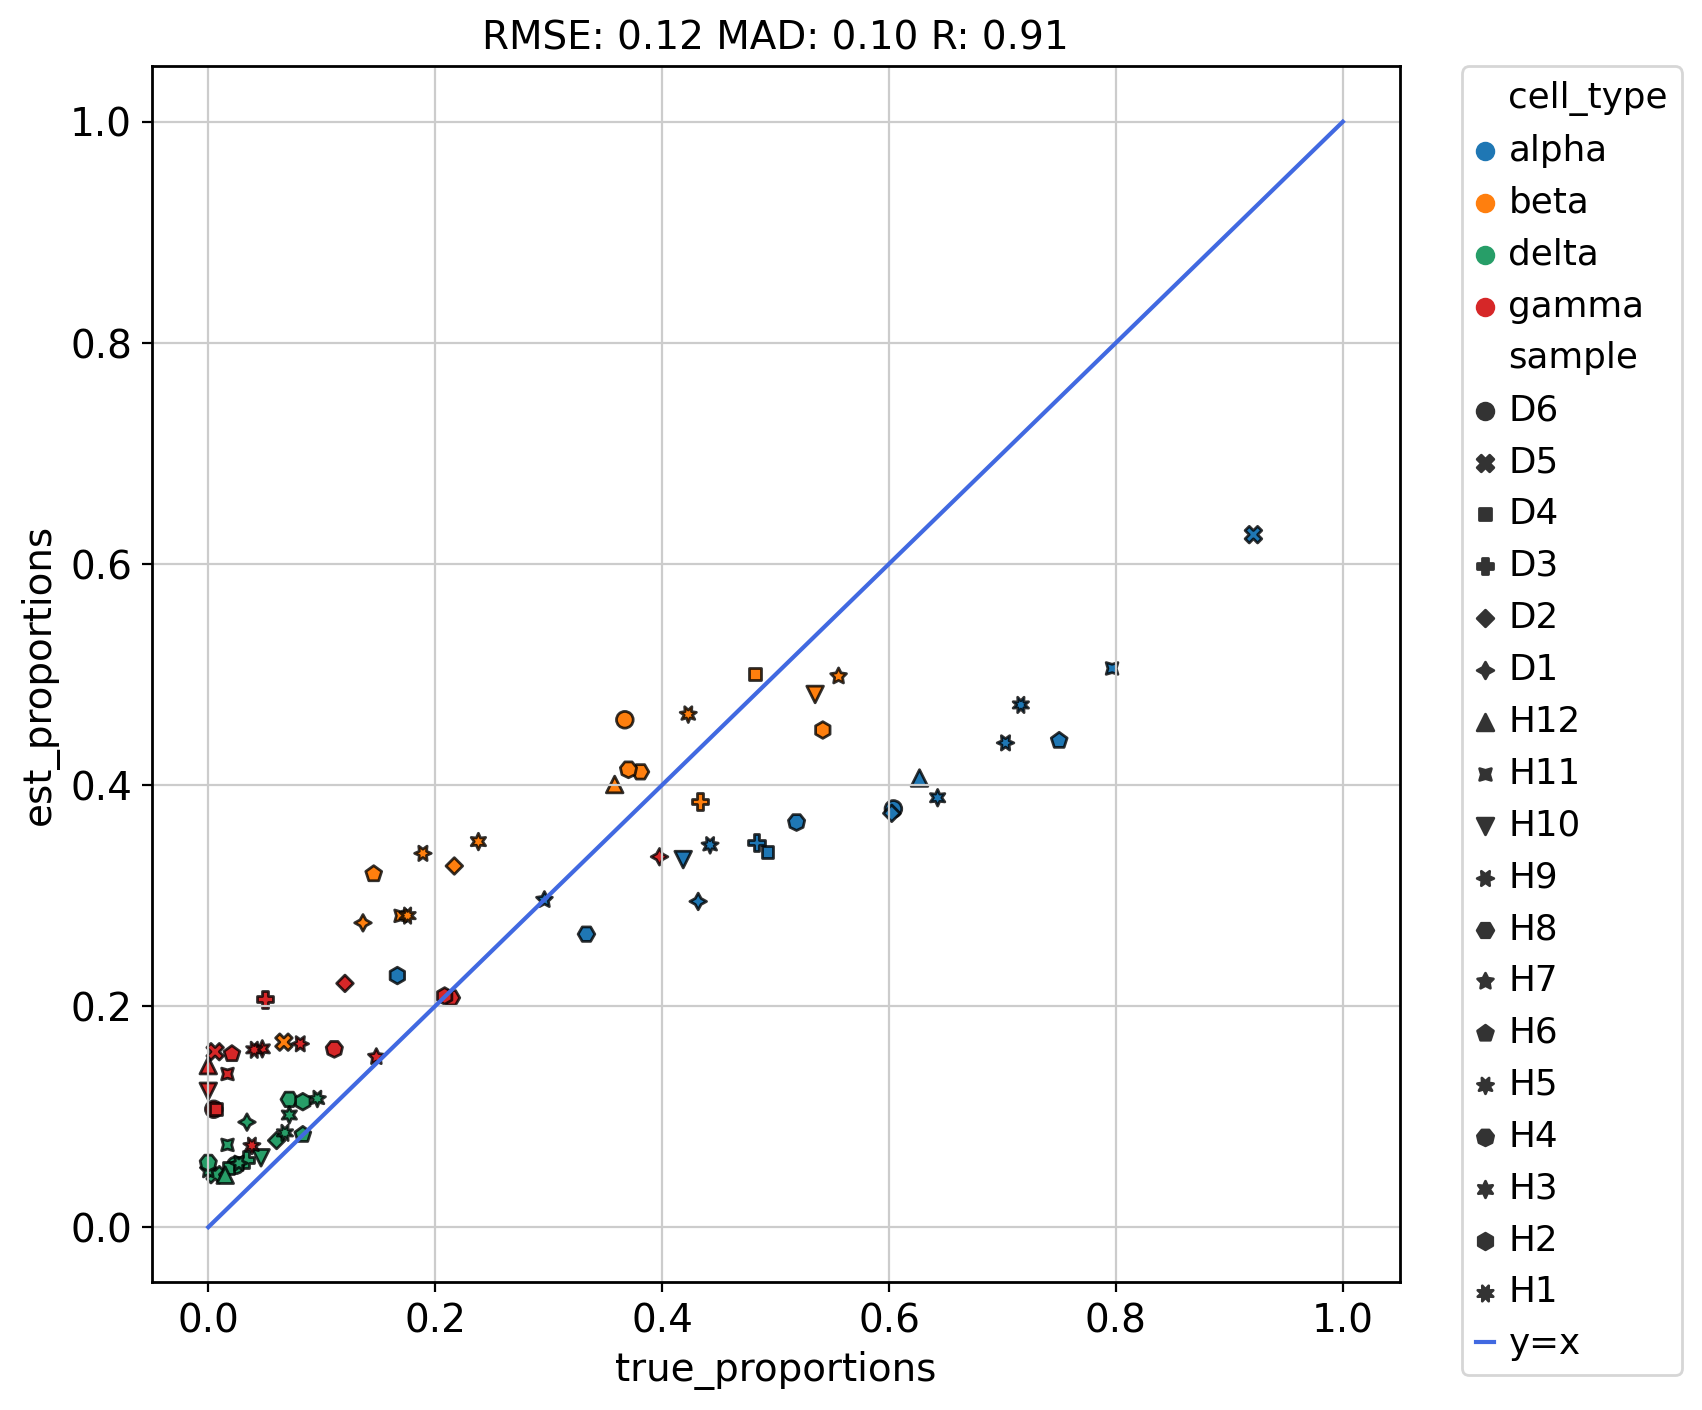

In [14]:
res = decon.deconvolute(
    model_type="lrm",
    num_epochs=5000, lr=0.1,
    use_outlier_genes=False,
    progress_bar=False,
    signature_quantiles=(0, 1.0), # 0,0.9
    log_loss=True
)
df_res = pd.DataFrame(res, columns=decon.cell_types, index=adata.uns["bulk_samples"])
dv.pl.scatter_check(true_df, df_res, style="sample")

In [15]:
pd.DataFrame({
    "MuSiC": [0.10, 0.06, 0.94],
    "NNLS": [0.17, 0.12, 0.82],
    "BSEQ-sc": [0.21, 0.15, 0.79],
    "CIBERSORT": [0.21, 0.15, 0.76],
    "Normal": [0.16, 0.10, 0.79],
    "Poisson": [0.06, 0.05, 0.97]},
    index=["RMSD", "mAD", "R"]
)

,MuSiC,NNLS,BSEQ-sc,CIBERSORT,Normal,Poisson
RMSD,0.10,0.17,0.21,0.21,0.16,0.06
mAD,0.06,0.12,0.15,0.15,0.10,0.05
R,0.94,0.82,0.79,0.76,0.79,0.97


In [16]:
def prediction_plot(adata, res, i):
    est_bulk = np.log1p(np.sum(adata.varm["mu_expression_cellType"] * res[i, :] * 800, axis=1))
    true_bulk = np.log1p(adata.varm["bulk"][:, i])

    _max = max(est_bulk.max(), true_bulk.max())
    mask = np.ones(len(est_bulk), dtype=bool)
    # mask = (bulk == 0)

    clr = adata.varm["pseudo_factor"][:, i][mask]
    zmin = clr.min()
    zmax = clr.max()
    zcenter = (0 - zmin) / (zmax - zmin)

    f = px.scatter(
        # x=est_bulk[mask],
        # y=true_bulk[mask],
        # log_x=True, log_y=True,
        # color=np.log1p(adata.varm["cv_cellType"].max(1))[mask],
        color=clr,
        color_continuous_scale=scout.ply.colors.seismic(zcenter),
        # trendline="ols",
    )
    f.add_trace(
        go.Scatter(x=[0, _max], y=[0, _max], mode="lines", line=dict(dash="dash"))
    )
    return f

prediction_plot(adata, res, 0)

KeyError: 'mu_expression_cellType'